In [1]:
import csv
import pandas as pd
import numpy as np
import string
import re
from zemberek import (
    TurkishSpellChecker,
    TurkishSentenceNormalizer,
    TurkishSentenceExtractor,
    TurkishMorphology,
    TurkishTokenizer
)
from trnlp import TrnlpWord
import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim_models
import gensim
from gensim.models import TfidfModel
import matplotlib.pyplot as plt
%matplotlib inline
from gensim.models import CoherenceModel

In [2]:
# verimizi zaten çekmiştik
data = pd.read_excel("TOGG_ALL.xlsx",header=None)
stop_words = pd.read_excel("guncel_durak.xlsx",header=None)
positive_words = pd.read_excel("guncel_pozitiff.xlsx",header=None)
negative_words = pd.read_excel("guncel_negatiff.xlsx",header=None)

data.columns = ['Togg yorumları']
positive_words.columns = ['positives']
negative_words.columns = ['negatives']
data.head()


,Togg yorumları
0,sevindiren gelişmedir. hayırlı olsun ülkemiz i...
1,seçim is coming.en az 1 milyon ortalama 1.5 mi...
2,yerli değil korosu sahneye çıkar.ülkenin imajı...
3,lan olm kaçıncıya açıyorsunuz bu fabrikayı? ge...
4,yıllardır yollarda olan arabamızın fabrikası s...


In [3]:
# noktalama işaretlerini ve büyük-küçük farkını ortadan kaldıralım, burada artık data cleaning yapıyoruz.
# noktalama işaretlerini data'mızdan kaldırmak için bir fonksiyon yazalım.
data["noktalamayok"] = data['Togg yorumları'].str.replace('[^\w\s]',' ')
data.head()

<>:3: DeprecationWarning: invalid escape sequence \w
<>:3: DeprecationWarning: invalid escape sequence \w
C:\Users\sozer\AppData\Local\Temp/ipykernel_4392/2863721896.py:3: DeprecationWarning: invalid escape sequence \w
  data["noktalamayok"] = data['Togg yorumları'].str.replace('[^\w\s]',' ')
C:\Users\sozer\AppData\Local\Temp/ipykernel_4392/2863721896.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  data["noktalamayok"] = data['Togg yorumları'].str.replace('[^\w\s]',' ')


,Togg yorumları,noktalamayok
0,sevindiren gelişmedir. hayırlı olsun ülkemiz i...,sevindiren gelişmedir hayırlı olsun ülkemiz i...
1,seçim is coming.en az 1 milyon ortalama 1.5 mi...,seçim is coming en az 1 milyon ortalama 1 5 mi...
2,yerli değil korosu sahneye çıkar.ülkenin imajı...,yerli değil korosu sahneye çıkar ülkenin imajı...
3,lan olm kaçıncıya açıyorsunuz bu fabrikayı? ge...,lan olm kaçıncıya açıyorsunuz bu fabrikayı ge...
4,yıllardır yollarda olan arabamızın fabrikası s...,yıllardır yollarda olan arabamızın fabrikası s...


In [4]:
# küçük harfe çeviriyoruzÜkelimelerimizi
data['noktalamayok'] = data['noktalamayok'].str.lower()

In [5]:
data['turkcekarakteryok'] = data['noktalamayok'].str.replace('ş','s')
data['turkcekarakteryok'] = data['turkcekarakteryok'].str.replace('ç','c')
data['turkcekarakteryok'] = data['turkcekarakteryok'].str.replace('ğ','g')
data['turkcekarakteryok'] = data['turkcekarakteryok'].str.replace('ı','i')
data['turkcekarakteryok'] = data['turkcekarakteryok'].str.replace('ü','u')
data['turkcekarakteryok'] = data['turkcekarakteryok'].str.replace('ö','o')


In [6]:
# aşağıdaki adımın kullanılıp kullanılmayacağına sonradan karar verilecek
#çünkü fiyatlamalar da önemli rol oynayabilir verisetinde
data['sayisalyok'] = data['turkcekarakteryok'].str.replace("\d","")

<>:3: DeprecationWarning: invalid escape sequence \d
<>:3: DeprecationWarning: invalid escape sequence \d
C:\Users\sozer\AppData\Local\Temp/ipykernel_4392/2432054027.py:3: DeprecationWarning: invalid escape sequence \d
  data['sayisalyok'] = data['turkcekarakteryok'].str.replace("\d","")
C:\Users\sozer\AppData\Local\Temp/ipykernel_4392/2432054027.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  data['sayisalyok'] = data['turkcekarakteryok'].str.replace("\d","")


In [7]:
# aşağıdaki kod satırında ise stop word'lerimizin bulunduğu dataframe'de yer alan kelimeleri data isimli dataframe'imizden kaldırıyoruz
data['tweet'] = data['sayisalyok'].apply(lambda x: ' '.join([word for word in str(x).split() if word not in stop_words.values]))
data.head()

,Togg yorumları,noktalamayok,turkcekarakteryok,sayisalyok,tweet
0,sevindiren gelişmedir. hayırlı olsun ülkemiz i...,sevindiren gelişmedir hayırlı olsun ülkemiz i...,sevindiren gelismedir hayirli olsun ulkemiz i...,sevindiren gelismedir hayirli olsun ulkemiz i...,sevindiren gelismedir hayirli ulkemiz umarim u...
1,seçim is coming.en az 1 milyon ortalama 1.5 mi...,seçim is coming en az 1 milyon ortalama 1 5 mi...,secim is coming en az 1 milyon ortalama 1 5 mi...,secim is coming en az milyon ortalama milyo...,secim coming ortalama tl satilacak arabanin fa...
2,yerli değil korosu sahneye çıkar.ülkenin imajı...,yerli değil korosu sahneye çıkar ülkenin imajı...,yerli degil korosu sahneye cikar ulkenin imaji...,yerli degil korosu sahneye cikar ulkenin imaji...,yerli korosu sahneye cikar ulkenin imaji ekono...
3,lan olm kaçıncıya açıyorsunuz bu fabrikayı? ge...,lan olm kaçıncıya açıyorsunuz bu fabrikayı ge...,lan olm kacinciya aciyorsunuz bu fabrikayi ge...,lan olm kacinciya aciyorsunuz bu fabrikayi ge...,lan olm kacinciya aciyorsunuz fabrikayi sene t...
4,yıllardır yollarda olan arabamızın fabrikası s...,yıllardır yollarda olan arabamızın fabrikası s...,yillardir yollarda olan arabamizin fabrikasi s...,yillardir yollarda olan arabamizin fabrikasi s...,yillardir yollarda arabamizin fabrikasi sonund...


In [8]:
#TrnlpWord kütüphanesi o kadar iyi sonuçlar vermedi.
#obj = TrnlpWord()
#obj.setword("bir sey")
#obj.get_stem
#data['tweet'].to_excel("toggpy.xlsx")

In [9]:
data = pd.read_excel("toggknime.xlsx",header=None)
data.columns=['Togg_yorumlari']
data.head()

,Togg_yorumlari
0,sevin geliş hayırlı ülke um üre araba dünya i...
1,seçim coming ortalama tl satilacak arabanin fa...
2,yerli koro sahne çıkar ülke imaj ekonomi güzel...
3,la olm kaçıncı aç fabrika sene tarih şey topl...
4,yıl yol araba fabrika sonunda ekim inşa bitir ...


In [10]:
# aşağıdak kod satirinda ise eğer 3 karakterden az kelimemiz bulunuyorsa kaldırıyorz, çünkü genelde
# Türkçe'de 3 kelimeden az kelimeler pek bir anlam ifade etmiyor. Zaten köklerini elde etmiştik.
data['karakterfiltreli'] = data['Togg_yorumlari'].apply(lambda x: ' '.join([word for word in str(x).split() if len(word)>3]))
data.head()

,Togg_yorumlari,karakterfiltreli
0,sevin geliş hayırlı ülke um üre araba dünya i...,sevin geliş hayırlı ülke araba dünya ihraç
1,seçim coming ortalama tl satilacak arabanin fa...,seçim coming ortalama satilacak arabanin fabri...
2,yerli koro sahne çıkar ülke imaj ekonomi güzel...,yerli koro sahne çıkar ülke imaj ekonomi güzel...
3,la olm kaçıncı aç fabrika sene tarih şey topl...,kaçıncı fabrika sene tarih toplu tören
4,yıl yol araba fabrika sonunda ekim inşa bitir ...,araba fabrika sonunda ekim inşa bitir aç…hava ...


In [11]:
#veride 3 kelimeden az olanları eledikten sonra tekrrdan stop word'leri elimine etmek faydalı olabilir.
data['stop_wordsuz'] = data['karakterfiltreli'].apply(lambda x: ' '.join([word for word in str(x).split() if word not in stop_words.values]))
data.head()

,Togg_yorumlari,karakterfiltreli,stop_wordsuz
0,sevin geliş hayırlı ülke um üre araba dünya i...,sevin geliş hayırlı ülke araba dünya ihraç,sevin geliş hayırlı ülke araba ihraç
1,seçim coming ortalama tl satilacak arabanin fa...,seçim coming ortalama satilacak arabanin fabri...,seçim coming ortalama satilacak arabanin fabri...
2,yerli koro sahne çıkar ülke imaj ekonomi güzel...,yerli koro sahne çıkar ülke imaj ekonomi güzel...,yerli koro sahne çıkar ülke imaj ekonomi güzel...
3,la olm kaçıncı aç fabrika sene tarih şey topl...,kaçıncı fabrika sene tarih toplu tören,kaçıncı fabrika sene toplu tören
4,yıl yol araba fabrika sonunda ekim inşa bitir ...,araba fabrika sonunda ekim inşa bitir aç…hava ...,araba fabrika sonunda ekim inşa bitir aç…hava ...


In [12]:
def word_tokenize(sentence):
    acronym_each_dot = r"(?:[a-zğçşöüı]\.){2,}"
    acronym_end_dot = r"\b[a-zğçşöüı]{2,3}\."
    suffixes = r"[a-zğçşöüı]{3,}' ?[a-zğçşöüı]{0,3}"
    numbers = r"\d+[.,:\d]+"
    any_word = r"[a-zğçşöüı]+"
    punctuations = r"[a-zğçşöüı]*[.,!?;:]"
    word_regex = "|".join([acronym_each_dot,acronym_end_dot,suffixes,numbers,any_word,punctuations])
    sentence = re.compile("%s"%word_regex, re.I).findall(sentence)
    return sentence

In [13]:
data['tokenized'] = data['stop_wordsuz'].apply(lambda x : word_tokenize(x))
data.head()

,Togg_yorumlari,karakterfiltreli,stop_wordsuz,tokenized
0,sevin geliş hayırlı ülke um üre araba dünya i...,sevin geliş hayırlı ülke araba dünya ihraç,sevin geliş hayırlı ülke araba ihraç,"[sevin, geliş, hayırlı, ülke, araba, ihraç]"
1,seçim coming ortalama tl satilacak arabanin fa...,seçim coming ortalama satilacak arabanin fabri...,seçim coming ortalama satilacak arabanin fabri...,"[seçim, coming, ortalama, satilacak, arabanin,..."
2,yerli koro sahne çıkar ülke imaj ekonomi güzel...,yerli koro sahne çıkar ülke imaj ekonomi güzel...,yerli koro sahne çıkar ülke imaj ekonomi güzel...,"[yerli, koro, sahne, çıkar, ülke, imaj, ekonom..."
3,la olm kaçıncı aç fabrika sene tarih şey topl...,kaçıncı fabrika sene tarih toplu tören,kaçıncı fabrika sene toplu tören,"[kaçıncı, fabrika, sene, toplu, tören]"
4,yıl yol araba fabrika sonunda ekim inşa bitir ...,araba fabrika sonunda ekim inşa bitir aç…hava ...,araba fabrika sonunda ekim inşa bitir aç…hava ...,"[araba, fabrika, sonunda, ekim, inşa, bitir, a..."


In [14]:
#Şimdi artık verimizi önişlemden geçirdik ve LDA yani Topic Modeling uygulayabiliriz.
#Create a Gensim dictionary from the tokenized data 
tokenized = data['tokenized']
#Creating term dictionary of corpus, where each unique term is assigned an index.
id2word = corpora.Dictionary(tokenized)
#Filter terms which occurs in less than 1 query and more than 80% of the queries.
id2word.filter_extremes(no_below=1, no_above=0.8)
#convert the dictionary to a bag of words corpus 
corpus = [id2word.doc2bow(tokens) for tokens in tokenized]
print(corpus[:1])

2022-11-08 22:03:20,598 - gensim.corpora.dictionary - INFO
Msg: adding document #0 to Dictionary<0 unique tokens: []>

2022-11-08 22:03:20,912 - gensim.corpora.dictionary - INFO
Msg: built Dictionary<15683 unique tokens: ['araba', 'geliş', 'hayırlı', 'ihraç', 'sevin']...> from 5814 documents (total 138156 corpus positions)

2022-11-08 22:03:20,940 - gensim.utils - INFO
Msg: Dictionary lifecycle event {'msg': "built Dictionary<15683 unique tokens: ['araba', 'geliş', 'hayırlı', 'ihraç', 'sevin']...> from 5814 documents (total 138156 corpus positions)", 'datetime': '2022-11-08T22:03:20.913632', 'gensim': '4.2.0', 'python': '3.9.6 (default, Aug 18 2021, 15:44:49) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'created'}

2022-11-08 22:03:20,951 - gensim.corpora.dictionary - INFO
Msg: discarding 0 tokens: []...

2022-11-08 22:03:20,953 - gensim.corpora.dictionary - INFO
Msg: keeping 15683 tokens which were in no less than 1 and no more than 4651 (=80.0%) doc

In [15]:
bigrams_phrases = gensim.models.Phrases(tokenized,min_count=5,threshold=50)
trigram_phrases = gensim.models.Phrases(bigrams_phrases[tokenized],threshold=50)
bigram = gensim.models.phrases.Phraser(bigrams_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return [bigram[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram[bigram[doc]] for doc in texts]

data_bigrams = make_bigrams(tokenized)
data_bigrams_trigrams = make_trigrams(data_bigrams)

print(data_bigrams_trigrams[1])


2022-11-08 22:03:21,337 - gensim.models.phrases - INFO
Msg: collecting all words and their counts

2022-11-08 22:03:21,339 - gensim.models.phrases - INFO
Msg: PROGRESS: at sentence #0, processed 0 words and 0 word types

2022-11-08 22:03:21,664 - gensim.models.phrases - INFO
Msg: collected 112087 token types (unigram + bigrams) from a corpus of 138156 words and 5814 sentences

2022-11-08 22:03:21,665 - gensim.models.phrases - INFO
Msg: merged Phrases<112087 vocab, min_count=5, threshold=50, max_vocab_size=40000000>

2022-11-08 22:03:21,665 - gensim.utils - INFO
Msg: Phrases lifecycle event {'msg': 'built Phrases<112087 vocab, min_count=5, threshold=50, max_vocab_size=40000000> in 0.33s', 'datetime': '2022-11-08T22:03:21.665923', 'gensim': '4.2.0', 'python': '3.9.6 (default, Aug 18 2021, 15:44:49) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'created'}

2022-11-08 22:03:21,666 - gensim.models.phrases - INFO
Msg: collecting all words and their counts

2

In [16]:
id2word = corpora.Dictionary(data_bigrams_trigrams)
texts = data_bigrams_trigrams
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[4])

tfidf = TfidfModel(corpus, id2word=id2word)
low_value=0.03
words = []
words_missing_in_tfidf = []

for i in range(0,len(corpus)):
    bow = corpus[i]
    low_value_words = []
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids]
    

2022-11-08 22:03:24,419 - gensim.corpora.dictionary - INFO
Msg: adding document #0 to Dictionary<0 unique tokens: []>

2022-11-08 22:03:24,723 - gensim.corpora.dictionary - INFO
Msg: built Dictionary<15862 unique tokens: ['araba', 'geliş', 'hayırlı', 'ihraç', 'sevin']...> from 5814 documents (total 135005 corpus positions)

2022-11-08 22:03:24,724 - gensim.utils - INFO
Msg: Dictionary lifecycle event {'msg': "built Dictionary<15862 unique tokens: ['araba', 'geliş', 'hayırlı', 'ihraç', 'sevin']...> from 5814 documents (total 135005 corpus positions)", 'datetime': '2022-11-08T22:03:24.724105', 'gensim': '4.2.0', 'python': '3.9.6 (default, Aug 18 2021, 15:44:49) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'created'}

[(0, 1), (35, 3), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 2), (47, 1), (48, 2)]
2022-11-08 22:03:25,306 - gensim.models.tfidfmodel - INFO
Msg: collecting document frequencies

2022-11-08 22:03:25,307 - gensim.models.tfidf

In [17]:
#özellikle herhangi bir cümlede geçen kelimenin kaç kez tekrarlandığına bakalım, mesela cumhuriyet ve turki kelimeleri 2 kez geçmekte
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[12:13]]

[[('hayırlı', 1),
  ('seçim', 1),
  ('çıkar', 1),
  ('inşallah', 1),
  ('adım', 1),
  ('büyük', 1),
  ('fiyat', 1),
  ('herkesimden', 1),
  ('ihtimal', 1),
  ('vatandaş', 1)]]

In [18]:
#LDA
ldamodel = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                           num_topics = 5, 
                                           random_state=100,
                                           id2word=id2word,
                                            
                            
                                           passes=15,
                                           alpha='auto')
ldamodel.save('mOdel.gensim')
topics = ldamodel.print_topics(num_words=10) 

2022-11-08 22:03:27,652 - gensim.models.ldamodel - INFO
Msg: using autotuned alpha, starting with [0.2, 0.2, 0.2, 0.2, 0.2]

2022-11-08 22:03:27,654 - gensim.models.ldamodel - INFO
Msg: using symmetric eta at 0.2

2022-11-08 22:03:27,662 - gensim.models.ldamodel - INFO
Msg: using serial LDA version on this node

2022-11-08 22:03:27,678 - gensim.models.ldamodel - INFO
Msg: running online (multi-pass) LDA training, 5 topics, 15 passes over the supplied corpus of 5814 documents, updating model once every 2000 documents, evaluating perplexity every 5814 documents, iterating 50x with a convergence threshold of 0.001000

2022-11-08 22:03:27,679 - gensim.models.ldamodel - INFO
Msg: PROGRESS: pass 0, at document #2000/5814

2022-11-08 22:03:29,131 - gensim.models.ldamodel - INFO
Msg: optimized alpha [0.15337878, 0.13323432, 0.19091828, 0.13732377, 0.1918372]

2022-11-08 22:03:29,140 - gensim.models.ldamodel - INFO
Msg: merging changes from 2000 documents into a model of 5814 documents

2022-11

In [19]:
# sonuçlara bakalım, hangi topiclerimiz mevcut
for topic in topics:
    print(topic,"\n")

(0, '0.021*"togg" + 0.006*"telefon" + 0.005*"kapı" + 0.004*"fabrikası" + 0.004*"domain" + 0.003*"soru" + 0.003*"cevap" + 0.003*"dava" + 0.002*"canlı_yayın" + 0.002*"arsa"') 

(1, '0.004*"hoca" + 0.003*"ekran" + 0.003*"profesyonel" + 0.003*"canlı" + 0.002*"araba" + 0.002*"çocuğ" + 0.002*"saray" + 0.002*"kervan" + 0.002*"heykel" + 0.002*"tuvalet"') 

(2, '0.026*"araba" + 0.020*"yerli" + 0.016*"otomobil" + 0.015*"ülke" + 0.014*"proje" + 0.014*"togg" + 0.012*"fabrika" + 0.010*"üretim" + 0.008*"türkiye" + 0.007*"para"') 

(3, '0.012*"arac" + 0.008*"togg" + 0.008*"elektrik" + 0.006*"uretim" + 0.005*"model" + 0.005*"sene" + 0.004*"buyuk" + 0.003*"turki" + 0.003*"otomobil" + 0.003*"konu"') 

(4, '0.035*"araç" + 0.029*"fiyat" + 0.024*"elektrik" + 0.018*"araba" + 0.017*"togg" + 0.016*"arac" + 0.010*"model" + 0.010*"piyasa" + 0.010*"vergi" + 0.009*"dolar"') 



In [20]:
#Doküman-Topic matrixi dokümanların topiclere dağılım olasılığını içeriyor. Hadi bu matrixi hangi dökümanın hangi topice ait olduğunu bulmak için kullanalım. 
get_document_topics = ldamodel.get_document_topics(corpus[0])
print(get_document_topics)

[(0, 0.01002952), (2, 0.89468765), (4, 0.08029446)]


In [21]:
#visualizing topics
lda_viz = gensim.models.ldamodel.LdaModel.load('mOdel.gensim')#load lda model
lda_display = pyLDAvis.gensim_models.prepare(lda_viz, corpus, id2word, sort_topics=True)
pyLDAvis.display(lda_display)

2022-11-08 22:04:05,210 - gensim.utils - INFO
Msg: loading LdaModel object from mOdel.gensim

2022-11-08 22:04:05,213 - gensim.utils - INFO
Msg: loading expElogbeta from mOdel.gensim.expElogbeta.npy with mmap=None

2022-11-08 22:04:05,216 - gensim.utils - INFO
Msg: setting ignored attribute state to None

2022-11-08 22:04:05,218 - gensim.utils - INFO
Msg: setting ignored attribute dispatcher to None

2022-11-08 22:04:05,219 - gensim.utils - INFO
Msg: setting ignored attribute id2word to None

2022-11-08 22:04:05,220 - gensim.utils - INFO
Msg: LdaModel lifecycle event {'fname': 'mOdel.gensim', 'datetime': '2022-11-08T22:04:05.220560', 'gensim': '4.2.0', 'python': '3.9.6 (default, Aug 18 2021, 15:44:49) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'loaded'}

2022-11-08 22:04:05,221 - gensim.utils - INFO
Msg: loading LdaState object from mOdel.gensim.state

2022-11-08 22:04:05,223 - gensim.utils - INFO
Msg: LdaState lifecycle event {'fname': 'mOdel.gensi

c:\Users\sozer\anaconda3\envs\ENV_NAME\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [22]:
def dominant_topic(ldamodel,corpus,content):
     #Function to find the dominant topic in each query
     sent_topics_df = pd.DataFrame() 
     # Get main topic in each query
     for i, row in enumerate(ldamodel[corpus]):
         row = sorted(row, key=lambda x: (x[1]), reverse=True)
         # Get the Dominant topic, Perc Contribution and Keywords for each query
         for j, (topic_num, prop_topic) in enumerate(row):
             if j == 0:  # => dominant topic
                 wp = ldamodel.show_topic(topic_num,topn=30)
                 topic_keywords = ", ".join([word for word, prop in wp])
                 sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
             else:
                 break
     sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
     contents = pd.Series(content)#noisy data
     sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
     return(sent_topics_df)
df_dominant_topic = dominant_topic(ldamodel=ldamodel, corpus=corpus, content=data['stop_wordsuz']) 
df_dominant_topic.head(10)

,Dominant_Topic,Perc_Contribution,Topic_Keywords,stop_wordsuz
0,2.0,0.8947,"araba, yerli, otomobil, ülke, proje, togg, fab...",sevin geliş hayırlı ülke araba ihraç
1,4.0,0.3843,"araç, fiyat, elektrik, araba, togg, arac, mode...",seçim coming ortalama satilacak arabanin fabri...
2,2.0,0.9340,"araba, yerli, otomobil, ülke, proje, togg, fab...",yerli koro sahne çıkar ülke imaj ekonomi güzel...
3,2.0,0.8905,"araba, yerli, otomobil, ülke, proje, togg, fab...",kaçıncı fabrika sene toplu tören
4,2.0,0.9589,"araba, yerli, otomobil, ülke, proje, togg, fab...",araba fabrika sonunda ekim inşa bitir aç…hava ...
5,2.0,0.8447,"araba, yerli, otomobil, ülke, proje, togg, fab...",maalesef hayal kırık aday
6,2.0,0.9793,"araba, yerli, otomobil, ülke, proje, togg, fab...",yerli milli düşman ilan sene uçak uzay mekiğ t...
7,2.0,0.9271,"araba, yerli, otomobil, ülke, proje, togg, fab...",ekşi kardeş çamur kafa patla tanım mutlu tane
8,2.0,0.8517,"araba, yerli, otomobil, ülke, proje, togg, fab...",togg bıkkın getir geliş ekonomi özel sektör ar...
9,2.0,0.9661,"araba, yerli, otomobil, ülke, proje, togg, fab...",türkiye adım cumhuriyet ilan anlam önem denk g...


In [23]:
df_dominant_topic.head(10)

,Dominant_Topic,Perc_Contribution,Topic_Keywords,stop_wordsuz
0,2.0,0.8947,"araba, yerli, otomobil, ülke, proje, togg, fab...",sevin geliş hayırlı ülke araba ihraç
1,4.0,0.3843,"araç, fiyat, elektrik, araba, togg, arac, mode...",seçim coming ortalama satilacak arabanin fabri...
2,2.0,0.9340,"araba, yerli, otomobil, ülke, proje, togg, fab...",yerli koro sahne çıkar ülke imaj ekonomi güzel...
3,2.0,0.8905,"araba, yerli, otomobil, ülke, proje, togg, fab...",kaçıncı fabrika sene toplu tören
4,2.0,0.9589,"araba, yerli, otomobil, ülke, proje, togg, fab...",araba fabrika sonunda ekim inşa bitir aç…hava ...
5,2.0,0.8447,"araba, yerli, otomobil, ülke, proje, togg, fab...",maalesef hayal kırık aday
6,2.0,0.9793,"araba, yerli, otomobil, ülke, proje, togg, fab...",yerli milli düşman ilan sene uçak uzay mekiğ t...
7,2.0,0.9271,"araba, yerli, otomobil, ülke, proje, togg, fab...",ekşi kardeş çamur kafa patla tanım mutlu tane
8,2.0,0.8517,"araba, yerli, otomobil, ülke, proje, togg, fab...",togg bıkkın getir geliş ekonomi özel sektör ar...
9,2.0,0.9661,"araba, yerli, otomobil, ülke, proje, togg, fab...",türkiye adım cumhuriyet ilan anlam önem denk g...


In [24]:
data = pd.concat([data,df_dominant_topic.iloc[:,0:3]],axis=1,join='outer')

In [25]:
data = data.drop(columns=['karakterfiltreli'])
data.head()

,Togg_yorumlari,stop_wordsuz,tokenized,Dominant_Topic,Perc_Contribution,Topic_Keywords
0,sevin geliş hayırlı ülke um üre araba dünya i...,sevin geliş hayırlı ülke araba ihraç,"[sevin, geliş, hayırlı, ülke, araba, ihraç]",2.0,0.8947,"araba, yerli, otomobil, ülke, proje, togg, fab..."
1,seçim coming ortalama tl satilacak arabanin fa...,seçim coming ortalama satilacak arabanin fabri...,"[seçim, coming, ortalama, satilacak, arabanin,...",4.0,0.3843,"araç, fiyat, elektrik, araba, togg, arac, mode..."
2,yerli koro sahne çıkar ülke imaj ekonomi güzel...,yerli koro sahne çıkar ülke imaj ekonomi güzel...,"[yerli, koro, sahne, çıkar, ülke, imaj, ekonom...",2.0,0.9340,"araba, yerli, otomobil, ülke, proje, togg, fab..."
3,la olm kaçıncı aç fabrika sene tarih şey topl...,kaçıncı fabrika sene toplu tören,"[kaçıncı, fabrika, sene, toplu, tören]",2.0,0.8905,"araba, yerli, otomobil, ülke, proje, togg, fab..."
4,yıl yol araba fabrika sonunda ekim inşa bitir ...,araba fabrika sonunda ekim inşa bitir aç…hava ...,"[araba, fabrika, sonunda, ekim, inşa, bitir, a...",2.0,0.9589,"araba, yerli, otomobil, ülke, proje, togg, fab..."


In [26]:
#data['deneme'] = ["Long" if ele  == "BULL" else "Short" for satir in data["stop_wordsuz"]]

In [27]:
positives_2=[]
negatives_2=[]
for i in range(data.shape[0]):
    negative_sayac=0
    positive_sayac=0
    for word in data.tokenized[i]:
        if word in negative_words.values:
            negative_sayac+=1
        elif word in positive_words.values:
            positive_sayac+=1
    positives_2.append(positive_sayac)
    negatives_2.append(negative_sayac)        

In [28]:
data['positive_sayac'] = positives_2
data['negative_sayac'] = negatives_2
def f(row):
    if row['positive_sayac'] == row['negative_sayac']:
        val = "nötr"
    elif row['positive_sayac'] > row['negative_sayac']:
        val = "pozitif"
    else:
        val = "negatif"
    return val
data['sentiment'] = data.apply(f, axis=1)
data

,Togg_yorumlari,stop_wordsuz,tokenized,Dominant_Topic,Perc_Contribution,Topic_Keywords,positive_sayac,negative_sayac,sentiment
0,sevin geliş hayırlı ülke um üre araba dünya i...,sevin geliş hayırlı ülke araba ihraç,"[sevin, geliş, hayırlı, ülke, araba, ihraç]",2.0,0.8947,"araba, yerli, otomobil, ülke, proje, togg, fab...",1,0,pozitif
1,seçim coming ortalama tl satilacak arabanin fa...,seçim coming ortalama satilacak arabanin fabri...,"[seçim, coming, ortalama, satilacak, arabanin,...",4.0,0.3843,"araç, fiyat, elektrik, araba, togg, arac, mode...",1,2,negatif
2,yerli koro sahne çıkar ülke imaj ekonomi güzel...,yerli koro sahne çıkar ülke imaj ekonomi güzel...,"[yerli, koro, sahne, çıkar, ülke, imaj, ekonom...",2.0,0.9340,"araba, yerli, otomobil, ülke, proje, togg, fab...",1,0,pozitif
3,la olm kaçıncı aç fabrika sene tarih şey topl...,kaçıncı fabrika sene toplu tören,"[kaçıncı, fabrika, sene, toplu, tören]",2.0,0.8905,"araba, yerli, otomobil, ülke, proje, togg, fab...",0,0,nötr
4,yıl yol araba fabrika sonunda ekim inşa bitir ...,araba fabrika sonunda ekim inşa bitir aç…hava ...,"[araba, fabrika, sonunda, ekim, inşa, bitir, a...",2.0,0.9589,"araba, yerli, otomobil, ülke, proje, togg, fab...",0,0,nötr
...,...,...,...,...,...,...,...,...,...
5809,bari panelvanını yap inovatif enişte hitap et,bari panelvanını inovatif enişte hitap,"[bari, panelvanını, inovatif, enişte, hitap]",3.0,0.4585,"arac, togg, elektrik, uretim, model, sene, buy...",0,0,nötr
5810,fatih altaylı bura halt jaws atla içer aktar...,fatih altaylı bura halt jaws atla içer aktar a...,"[fatih, altaylı, bura, halt, jaws, atla, içer,...",2.0,0.9211,"araba, yerli, otomobil, ülke, proje, togg, fab...",8,6,pozitif
5811,üretim band video paylaş kapasite başla seda...,üretim band video paylaş kapasite seda model g...,"[üretim, band, video, paylaş, kapasite, seda, ...",2.0,0.6042,"araba, yerli, otomobil, ülke, proje, togg, fab...",0,1,negatif
5812,mustafa koç ticari intihar söylem katıl pazar ...,mustafa ticari intihar söylem katıl pazar yara...,"[mustafa, ticari, intihar, söylem, katıl, paza...",2.0,0.5145,"araba, yerli, otomobil, ülke, proje, togg, fab...",6,1,pozitif


In [29]:
data.head()

,Togg_yorumlari,stop_wordsuz,tokenized,Dominant_Topic,Perc_Contribution,Topic_Keywords,positive_sayac,negative_sayac,sentiment
0,sevin geliş hayırlı ülke um üre araba dünya i...,sevin geliş hayırlı ülke araba ihraç,"[sevin, geliş, hayırlı, ülke, araba, ihraç]",2.0,0.8947,"araba, yerli, otomobil, ülke, proje, togg, fab...",1,0,pozitif
1,seçim coming ortalama tl satilacak arabanin fa...,seçim coming ortalama satilacak arabanin fabri...,"[seçim, coming, ortalama, satilacak, arabanin,...",4.0,0.3843,"araç, fiyat, elektrik, araba, togg, arac, mode...",1,2,negatif
2,yerli koro sahne çıkar ülke imaj ekonomi güzel...,yerli koro sahne çıkar ülke imaj ekonomi güzel...,"[yerli, koro, sahne, çıkar, ülke, imaj, ekonom...",2.0,0.9340,"araba, yerli, otomobil, ülke, proje, togg, fab...",1,0,pozitif
3,la olm kaçıncı aç fabrika sene tarih şey topl...,kaçıncı fabrika sene toplu tören,"[kaçıncı, fabrika, sene, toplu, tören]",2.0,0.8905,"araba, yerli, otomobil, ülke, proje, togg, fab...",0,0,nötr
4,yıl yol araba fabrika sonunda ekim inşa bitir ...,araba fabrika sonunda ekim inşa bitir aç…hava ...,"[araba, fabrika, sonunda, ekim, inşa, bitir, a...",2.0,0.9589,"araba, yerli, otomobil, ülke, proje, togg, fab...",0,0,nötr


In [30]:
#topic_keywords = data.Topic_Keywords.value_counts().to_frame()
topic_keywords = data[['Dominant_Topic','Topic_Keywords','sentiment']]
#topic_keywords = topic_keywords.reset_index()
#topic_keywords.columns=['Dominant_Topic','Topic_Keywords']
topic_keywords = topic_keywords.groupby(by=['Dominant_Topic']).Topic_Keywords.value_counts().to_frame()
topic_keywords

,,Topic_Keywords
Dominant_Topic,Topic_Keywords,
0.0,"togg, telefon, kapı, fabrikası, domain, soru, cevap, dava, canlı_yayın, arsa, ankara, ortağ, proton, yumurta, lira, slogan, kefil, kanal, farasis, hoca, demek, kenar, logo, konsol, çekirdeğ, komşu, karn, tuhaf, varank, bagaj",205
1.0,"hoca, ekran, profesyonel, canlı, araba, çocuğ, saray, kervan, heykel, tuvalet, kafa, seci, gece, website, emeğ_sağlık, arkadas, porsche, troll, basari, vites, amca, pardon, seri, vadi, ornek, tane, komik, yoğurt, taşak, case",192
2.0,"araba, yerli, otomobil, ülke, proje, togg, fabrika, üretim, türkiye, para, araç, milli, insan, zaman, adam, devlet, konu, güzel, tasarım, şirket, anla, yatırım, mühendis, firma, halk, parça, büyük, kullan, başarı, ürün",3485
3.0,"arac, togg, elektrik, uretim, model, sene, buyuk, turki, otomobil, konu, aracin, tesla, araci, firma, teknoloji, arabayi, onemli, gercek, bina, guzel, arabanin, yeni, fiyati, turk, dogru, alirim, adam, tane, piyasa, satis",225
4.0,"araç, fiyat, elektrik, araba, togg, arac, model, piyasa, vergi, dolar, düşün, ucuz, türkiye, maliyet, lira, para, batarya, motor, tesla, pazar, otomobil, üretim, sene, kullan, zaman, euro, ülke, büyük, firma, alın",1707


In [31]:
data_group_topics = data.groupby(by=['Dominant_Topic']).sentiment.value_counts().to_frame()
#.sentiment.value_counts()
#data_group_topics.unstack()
data_group_topics
data_group_topics['yuzde'] = data_group_topics.groupby(level=0).transform(lambda x: (x / x.sum()).round(2))
data_group_topics

sentiment  yuzde
Dominant_Topic sentiment                  
0.0            nötr             129   0.63
               pozitif           58   0.28
               negatif           18   0.09
1.0            nötr             113   0.59
               pozitif           55   0.29
               negatif           24   0.12
2.0            pozitif         1566   0.45
               nötr            1338   0.38
               negatif          581   0.17
3.0            pozitif           97   0.43
               nötr              86   0.38
               negatif           42   0.19
4.0            pozitif          731   0.43
               nötr             703   0.41
               negatif          273   0.16

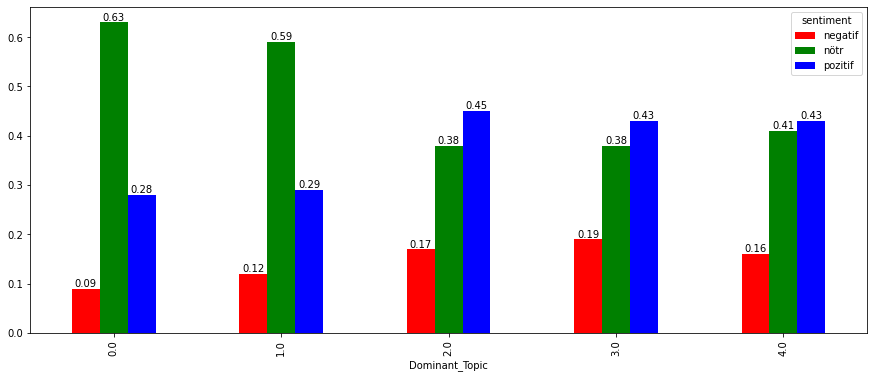

In [32]:
#pd.concat([data_group_topics,topic_keywords])
graf = data_group_topics.unstack().yuzde.plot(kind='bar', stacked=False,color=['r','g','b'],figsize=(15,6))
for deger in graf.containers:
    graf.bar_label(deger)